<a href="https://colab.research.google.com/github/vkthakur90/jupyter_notebooks/blob/master/Laplacian_of_Gaussian_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import google.colab.files as gcf

In [2]:
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import tensorflow.keras.models as tfkm
import tensorflow.keras.utils as tfku

In [3]:
(x_train, y_train), (x_test, y_test) = tfk.datasets.cifar10.load_data()

In [4]:
!ls

uploaded = gcf.upload()

for k, v in uploaded.items():
    with open(k, 'wb') as f:
        f.write(v)

!ls

sample_data  sid_kiara.jpg


sample_data  sid_kiara.jpg


In [5]:
img = tfku.load_img('sid_kiara.jpg', target_size = [480, 640], keep_aspect_ratio = True)
img_arr = tfku.img_to_array(img)

In [6]:
class UniformConv(tfkl.Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        inp = tfkl.Input(input_shape[1:])
        filter_layer = tfkl.DepthwiseConv2D((3, 3), use_bias = False, padding = 'same')

        filter_array = np.array([
            [1/9, 1/9, 1/9],
            [1/9, 1/9, 1/9],
            [1/9, 1/9, 1/9]
        ])[..., np.newaxis, np.newaxis]


        x = inp
        x = tfkl.Lambda(lambda t: tf.split(t, num_or_size_splits = input_shape[-1], axis = -1))(x)
        x = [filter_layer(t) for t in x]
        x = tfkl.Concatenate(axis = -1)(x)

        out = x

        filter_layer.set_weights([filter_array])

        filter_layer.trainable = False

        self.forward = tfkm.Model(inputs = [inp], outputs = [out])

    def call(self, input):
        return self.forward(input)

In [7]:
class GaussianConv(tfkl.Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        inp = tfkl.Input(input_shape[1:])
        gaussian = tfkl.DepthwiseConv2D((3, 3), use_bias = False, padding = 'same')

        gaussian_filter = np.array([
            [1/16, 2/16, 1/16],
            [2/16, 4/16, 2/16],
            [1/16, 2/16, 1/16]
        ])[..., np.newaxis, np.newaxis]


        x = inp
        x = tfkl.Lambda(lambda t: tf.split(t, num_or_size_splits = input_shape[-1], axis = -1))(x)
        x = [gaussian(t) for t in x]
        x = tfkl.Concatenate(axis = -1)(x)

        out = x

        gaussian.set_weights([gaussian_filter])

        gaussian.trainable = False

        self.forward = tfkm.Model(inputs = [inp], outputs = [out])

    def call(self, input):
        return self.forward(input)

In [8]:
class LaplacianConv(tfkl.Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        inp = tfkl.Input(input_shape[1:])
        laplacian = tfkl.DepthwiseConv2D((3, 3), use_bias = False, padding = 'same')

        laplacian_filter = np.array([
            [ 0.0, -1.0,  0.0],
            [-1.0,  4.0, -1.0],
            [ 0.0, -1.0,  0.0]
        ])[..., np.newaxis, np.newaxis]

        x = inp
        x = tfkl.Lambda(lambda t: tf.split(t, num_or_size_splits = input_shape[-1], axis = -1))(x)
        x = [laplacian(t) for t in x]
        x = tfkl.Concatenate(axis = -1)(x)

        out = x

        laplacian.set_weights([laplacian_filter])

        laplacian.trainable = False


        self.forward = tfkm.Model(inputs = [inp], outputs = [out])

    def call(self, input):
        return self.forward(input)

In [9]:
class PyramidConvFeatures(tfkl.Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        inp = tfkl.Input(input_shape[1:])

        x = inp
        x = tfkl.Rescaling(scale = 1/127.5, offset = -1)(x)

        y = x
        y = GaussianConv()(y)
        y = LaplacianConv()(y)
        x0 = y

        z1 = tfkl.MaxPool2D((2, 2))(x)
        z2 = tfkl.Lambda(lambda t: -t)(x)
        z2 = tfkl.MaxPool2D((2, 2))(z2)
        z2 = tfkl.Lambda(lambda t: -t)(z2)
        y = tfkl.Concatenate(axis = -1)([z1, z2])
        x = y
        y = GaussianConv()(y)
        y = LaplacianConv()(y)
        y = tfkl.ReLU()(y)
        y = GaussianConv()(y)
        x1 = y

        z1 = tfkl.MaxPool2D((2, 2))(x)
        z2 = tfkl.Lambda(lambda t: -t)(x)
        z2 = tfkl.MaxPool2D((2, 2))(z2)
        z2 = tfkl.Lambda(lambda t: -t)(z2)
        y = tfkl.Concatenate(axis = -1)([z1, z2])
        x = y
        y = GaussianConv()(y)
        y = LaplacianConv()(y)
        y = tfkl.ReLU()(y)
        y = GaussianConv()(y)
        x2 = y

        z1 = tfkl.MaxPool2D((2, 2))(x)
        z2 = tfkl.Lambda(lambda t: -t)(x)
        z2 = tfkl.MaxPool2D((2, 2))(z2)
        z2 = tfkl.Lambda(lambda t: -t)(z2)
        y = tfkl.Concatenate(axis = -1)([z1, z2])
        x = y
        y = GaussianConv()(y)
        y = LaplacianConv()(y)
        y = tfkl.ReLU()(y)
        y = GaussianConv()(y)
        x3 = y

        z1 = tfkl.MaxPool2D((2, 2))(x)
        z2 = tfkl.Lambda(lambda t: -t)(x)
        z2 = tfkl.MaxPool2D((2, 2))(z2)
        z2 = tfkl.Lambda(lambda t: -t)(z2)
        y = tfkl.Concatenate(axis = -1)([z1, z2])
        x = y
        y = GaussianConv()(y)
        y = LaplacianConv()(y)
        y = tfkl.ReLU()(y)
        y = GaussianConv()(y)
        x4 = y

        z1 = tfkl.MaxPool2D((2, 2))(x)
        z2 = tfkl.Lambda(lambda t: -t)(x)
        z2 = tfkl.MaxPool2D((2, 2))(z2)
        z2 = tfkl.Lambda(lambda t: -t)(z2)
        y = tfkl.Concatenate(axis = -1)([z1, z2])
        x = y
        y = GaussianConv()(y)
        y = LaplacianConv()(y)
        y = tfkl.ReLU()(y)
        y = GaussianConv()(y)
        x5 = y

        x = tfkl.UpSampling2D((2, 2), interpolation = 'nearest')(x5)

        x = tfkl.Concatenate(axis = -1)([x4, x])
        x = tfkl.UpSampling2D((2, 2), interpolation = 'nearest')(x)


        y = x3
        x = tfkl.Concatenate(axis = -1)([y, x])
        x = tfkl.UpSampling2D((2, 2), interpolation = 'nearest')(x)

        y = x2
        x = tfkl.Concatenate(axis = -1)([y, x])
        x = tfkl.UpSampling2D((2, 2), interpolation = 'nearest')(x)

        y = x1
        x = tfkl.Concatenate(axis = -1)([y, x])
        x = tfkl.UpSampling2D((2, 2), interpolation = 'nearest')(x)

        y = x0
        x = tfkl.Concatenate(axis = -1)([y, x])

        out = x

        self.forward = tfkm.Model(inputs = [inp], outputs = [out])

    def call(self, input):
        return self.forward(input)

In [10]:
model = tfkm.Sequential([
    tfkl.InputLayer([480, 640, 3]),
    PyramidConvFeatures(),
    tfkl.BatchNormalization(),
    tfkl.Dense(3, activation = 'tanh')
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pyramid_conv_features (Pyr  (None, 480, 640, 189)     153       
 amidConvFeatures)                                               
                                                                 
 batch_normalization (Batch  (None, 480, 640, 189)     756       
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 480, 640, 3)       570       
                                                                 
Total params: 1479 (5.78 KB)
Trainable params: 948 (3.70 KB)
Non-trainable params: 531 (2.07 KB)
_________________________________________________________________


In [12]:
train_img = img_arr[np.newaxis, ...]
pred_img = train_img/127.5 - 1

In [13]:
datasets = (
    tf.data.Dataset.from_tensor_slices((train_img, pred_img))
                   .repeat(10000)
                   .batch(8)
)

model.compile(
    optimizer = 'adam',
    loss = 'mean_squared_error'
)

model.fit(datasets)

1250/1250 [==============================] - 387s 299ms/step - loss: 0.0527


In [14]:
pred_x = model.predict(train_img)

norm_pred_x = np.uint8(255.0 * (pred_x - pred_x.min()) / (pred_x.max() - pred_x.min()))



1/1 [==============================] - 3s 3s/step


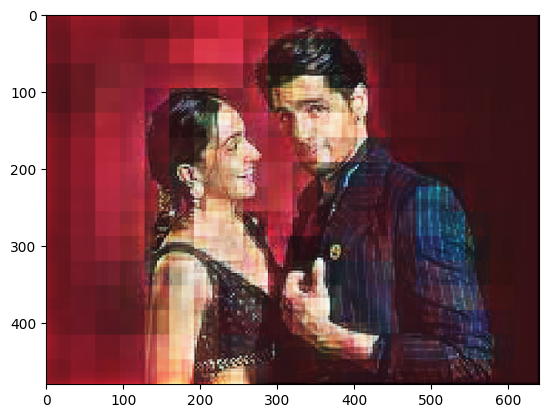

In [15]:
plt.imshow(norm_pred_x[0])

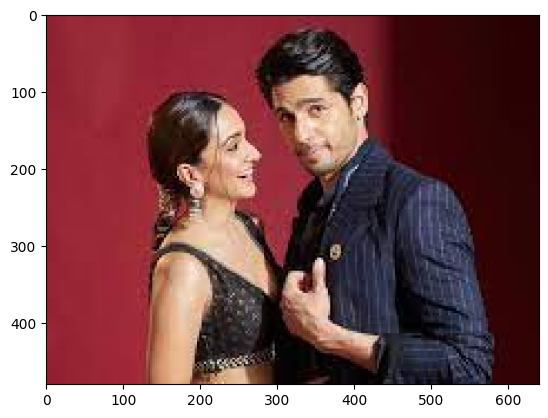

In [16]:
plt.imshow(np.uint8(img_arr))